# Линейная алгебра: сходство текстов и аппроксимация функций

Данное задание основано на материалах секции, посвященной введению в линейную алгебру. Вам понадобится компьютер с установленным интерпретатором Python и подключенными библиотеками NumPy и SciPy.

### Вы научитесь:
  * читать тексты из файла с помощью Python и разбивать их на слова
  * переводить тексты в векторные пространства, вычислять расстояния в этих пространствах
  * решать системы линейных уравнений
  * приближать любые функции с помощью многочленов
  
## Введение

В этом задании вы познакомитесь с некоторыми базовыми методами из линейной алгебры, реализованными в пакете SciPy — в частности, с методами подсчета косинусного расстояния и решения систем линейных уравнений. Обе эти задачи еще много раз встретятся нам в специализации. Так, на решении систем линейных уравнений основана настройка линейных моделей — очень большого и важного класса алгоритмов машинного обучения. Косинусное расстояние же часто используется в анализе текстов для измерения сходства между ними.

## Материалы

Справка по функциям пакета scipy.linalg: http://docs.scipy.org/doc/scipy/reference/linalg.html

Справка по работе с файлами в Python: https://docs.python.org/2/tutorial/inputoutput.html#reading-and-writing-files

Справка по регулярным выражениям в Python (если вы захотите узнать про них чуть больше): https://docs.python.org/2/library/re.html

## Задача 1: сравнение предложений

Дан набор предложений, скопированных с Википедии. Каждое из них имеет "кошачью тему" в одном из трех смыслов:

  * кошки (животные)
  * UNIX-утилита cat для вывода содержимого файлов
  * версии операционной системы OS X, названные в честь семейства кошачьих
Ваша задача — найти два предложения, которые ближе всего по смыслу к расположенному в самой первой строке. В качестве меры близости по смыслу мы будем использовать косинусное расстояние.

#### Выполните следующие шаги:

1. Скачайте файл с предложениями (sentences.txt).
2. Каждая строка в файле соответствует одному предложению. Считайте их, приведите каждую к нижнему регистру с помощью строковой функции lower().
3. Произведите токенизацию, то есть разбиение текстов на слова. Для этого можно воспользоваться регулярным выражением, которое считает разделителем любой символ, не являющийся буквой: re.split('[^a-z]', t). Не забудьте удалить пустые слова после разделения.
4. Составьте список всех слов, встречающихся в предложениях. Сопоставьте каждому слову индекс от нуля до (d - 1), где d — число различных слов в предложениях. Для этого удобно воспользоваться структурой dict.
5. Создайте матрицу размера n x d, где n — число предложений. Заполните ее: элемент с индексом (i, j) в этой матрице должен быть равен количеству вхождений j-го слова в i-е предложение. У вас должна получиться матрица размера 22 * 254.
6. Найдите косинусное расстояние от предложения в самой первой строке (In comparison to dogs, cats have not undergone...) до всех остальных с помощью функции scipy.spatial.distance.cosine. Какие номера у двух предложений, ближайших к нему по этому расстоянию (строки нумеруются с нуля)? Эти два числа и будут ответами на задание.
7. Запишите полученные числа в файл, разделив пробелом. Обратите внимание, что файл должен состоять из одной строки, в конце которой не должно быть переноса. Пример файла с решением вы можете найти в конце задания (submission-1.txt).
8. Совпадают ли ближайшие два предложения по тематике с первым? Совпадают ли тематики у следующих по близости предложений?

Разумеется, использованный вами метод крайне простой. Например, он не учитывает формы слов (так, cat и cats он считает разными словами, хотя по сути они означают одно и то же), не удаляет из текстов артикли и прочие ненужные слова. Позже мы будем подробно изучать анализ текстов, где выясним, как достичь высокого качества в задаче поиска похожих предложений.

In [35]:
import pandas as pd
import numpy as np
from scipy import spatial
import re

In [3]:
with open('sentences.txt') as input_file:
    sentences = input_file.readlines()

In [14]:
sentences = map(lambda x: x.strip().lower(), sentences)
num_sentences = len(sentences)

In [11]:
sentence_tokens = map(lambda s: filter(lambda x: x!= '', re.split('[^a-z]', s)), sentences)

In [15]:
words = {}
curr_index = 0
for sentence_token in sentence_tokens:
    for token in sentence_token:
        if token not in words:
            words[token] = curr_index
            curr_index += 1

In [19]:
num_words = len(words)

In [22]:
matrix = np.zeros((num_sentences, num_words))

In [26]:
for i in range(num_sentences):
    tokens = sentence_tokens[i]
    for token in tokens:
        matrix[i][words[token]] += 1

In [41]:
distances = {}

first_sentence_metric = matrix[0, :]
for i in range(num_sentences):
    cmp_sentence_metric = matrix[i, :]
    
    distances[i] = spatial.distance.cosine(first_sentence_metric, cmp_sentence_metric)        

In [45]:
distances_df = pd.DataFrame.from_dict(distances, orient = 'index')
distances_df.columns = ['distance']
distances_df['sentence'] = map(lambda x: sentences[x], distances_df.index.values)

In [47]:
distances_df.sort('distance')[:5]

/Library/Python/2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,distance,sentence
0,0.000000,"in comparison to dogs, cats have not undergone..."
6,0.732739,domestic cats are similar in size to the other...
4,0.777089,"in one, people deliberately tamed cats in a pr..."
21,0.825036,"the fifth major update to mac os x, leopard, c..."
10,0.832817,cat command is one of the basic commands that ...


## Задача 2: аппроксимация функции

Рассмотрим сложную математическую функцию на отрезке [1, 15]:

f(x) = sin(x / 5) * exp(x / 10) + 5 * exp(-x / 2)

Она может описывать, например, зависимость оценок, которые выставляют определенному сорту вина эксперты, в зависимости от возраста этого вина. По сути, задача машинного обучения состоит в том, чтобы приблизить сложную зависимость с помощью функции из определенного семейства. В этом задании мы будем приближать указанную функцию с помощью многочленов.

Как известно, многочлен степени n (то есть w_0 + w_1 x + w_2 x^2 + ... + w_n x^n) однозначно определяется любыми n + 1 различными точками, через которые он проходит. Это значит, что его коэффициенты w_0, ... w_n можно определить из следующей системы линейных уравнений:


где через x_1, ..., x_n, x_{n+1} обозначены точки, через которые проходит многочлен, а через f(x_1), ..., f(x_n), f(x_{n+1}) — значения, которые он должен принимать в этих точках.

Воспользуемся описанным свойством, и будем находить приближение функции многочленом, решая систему линейных уравнений.

1. Сформируйте систему линейных уравнений (то есть задайте матрицу коэффициентов A и свободный вектор b) для многочлена первой степени, который должен совпадать с функцией f в точках 1 и 15. Решите данную систему с помощью функции scipy.linalg.solve. Нарисуйте функцию f и полученный многочлен. Хорошо ли он приближает исходную функцию?
2. Повторите те же шаги для многочлена второй степени, который совпадает с функцией f в точках 1, 8 и 15. Улучшилось ли качество аппроксимации?
3. Повторите те же шаги для многочлена третьей степени, который совпадает с функцией f в точках 1, 4, 10 и 15. Хорошо ли он аппроксимирует функцию? Коэффициенты данного многочлена (четыре числа в следующем порядке: w_0, w_1, w_2, w_3) являются ответом на задачу. Округлять коэффициенты не обязательно, но при желании можете произвести округление до второго знака (т.е. до числа вида 0.42)
4. Запишите полученные числа в файл, разделив пробелами. Обратите внимание, что файл должен состоять из одной строки, в конце которой не должно быть переноса. Пример файла с решением вы можете найти в конце задания (submission-2.txt).

In [55]:
%matplotlib inline
import math
from matplotlib import pyplot as plt

def f(x):
    return math.sin(x/5.)*math.exp(x/10.) + 5*math.exp(-x/2.) 

In [62]:
x = np.arange(1, 16, 0.1)
y = map(f, x)

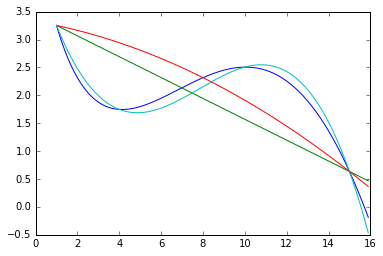

In [83]:
plt.plot(x, y)
plt.plot(x, y_approx_2)
plt.plot(x, y_approx_3)
plt.plot(x, y_approx_4)

In [76]:
def get_matrix(x_points):
    n = len(x_points)
    matrix = []
    for x in x_points:
        row = []
        for i in range(n):
            row.append(x**i)
        matrix.append(row)
    return np.array(matrix)

def get_approximate_values(w, x_points):
    y = []
    for x in x_points:
        y_curr = 0
        for i in range(len(w)):
            y_curr += w[i]*(x ** i)
        y.append(y_curr)
    return y



In [79]:
x_2 = [1, 15]
A_2 = get_matrix(x_2)
y_2 = np.array(map(f, x_2))
w_2 = scipy.linalg.solve(A_2, y_2)
y_approx_2 = get_approximate_values(w_2, x) 

In [80]:
x_3 = [1, 8, 15]
A_3 = get_matrix(x_3)
y_3 = np.array(map(f, x_3))
w_3 = scipy.linalg.solve(A_3, y_3)
y_approx_3 = get_approximate_values(w_3, x) 

In [82]:
x_4 = [1, 4, 10, 15]
A_4 = get_matrix(x_4)
y_4 = np.array(map(f, x_4))
w_4 = scipy.linalg.solve(A_4, y_4)
y_approx_4 = get_approximate_values(w_4, x) 

In [85]:
print w_4

[ 4.36264154 -1.29552587  0.19333685 -0.00823565]
